<a href="https://colab.research.google.com/github/MohamedAbuAmira/ML-DL-Examples/blob/master/Text_classification_with_an_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

from https://www.tensorflow.org/tutorials/text/text_classification_rnn

# Setup

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

# Setup input pipeline

The IMDB large movie review dataset is a binary classification dataset—all the reviews have either a positive or negative sentiment

In [3]:
# Download the dataset using TFDS

dataset, info=tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)

train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteZP7MNY/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteZP7MNY/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteZP7MNY/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


The dataset **info** includes the encoder (a `tfds.features.text.SubwordTextEncoder`).

In [4]:
encoder=info.features['text'].encoder

In [5]:
print(encoder.subwords[:20])

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_']


In [6]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


**This text encoder will reversibly encode any string, falling back to byte-encoding if necessary.**



In [7]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [8]:
assert original_string == sample_string

In [9]:
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


# Prepare the data for training

* Next create batches of these encoded strings. 
* Use the `padded_batch method` to zero-pad the sequences to the length of the longest string in the batch:

In [10]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [11]:
train_dataset=train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset=test_dataset.padded_batch(BATCH_SIZE)

# Create the model

* Build a `tf.keras.Sequential` model and start with an **embedding layer**. 
* An **embedding layer** stores one vector per word. 
* When called, it **converts the sequences of word indices to sequences of vectors**.
* These vectors are trainable. 
* After training (on enough data), words with similar meanings often have similar vectors.

* This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a tf.keras.layers.Dense layer.



* A **recurrent neural network (RNN)** processes sequence input by iterating through the elements.
*  RNNs pass the outputs from one timestep to their input—and then to the next.



* The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. 
* This propagates the input forward and backwards through the RNN layer and then concatenates the output. 
* This helps the RNN to learn long range dependencies.

In [12]:
model=tf.keras.Sequential([
                           tf.keras.layers.Embedding(encoder.vocab_size, 64),
                           tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                           tf.keras.layers.Dense(64, activation='relu'),
                           tf.keras.layers.Dense(1)
])



* we choose to Keras sequential model here since all the layers in the model only have single input and produce single output. 
* In case you want to use **stateful RNN layer**, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. 

Compile the Keras model to configure the training process:



In [13]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# Train the model

In [14]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 45s 115ms/step - loss: 0.6334 - accuracy: 0.5678 - val_loss: 0.4133 - val_accuracy: 0.7943
Epoch 2/10
391/391 [==============================] - 45s 114ms/step - loss: 0.3192 - accuracy: 0.8650 - val_loss: 0.3732 - val_accuracy: 0.8682
Epoch 3/10
391/391 [==============================] - 44s 114ms/step - loss: 0.2363 - accuracy: 0.9104 - val_loss: 0.3372 - val_accuracy: 0.8469
Epoch 4/10
391/391 [==============================] - 45s 116ms/step - loss: 0.1956 - accuracy: 0.9279 - val_loss: 0.3802 - val_accuracy: 0.8417
Epoch 5/10
391/391 [==============================] - 45s 115ms/step - loss: 0.1699 - accuracy: 0.9399 - val_loss: 0.3687 - val_accuracy: 0.8693
Epoch 6/10
391/391 [==============================] - 46s 117ms/step - loss: 0.1487 - accuracy: 0.9480 - val_loss: 0.4092 - val_accuracy: 0.8630
Epoch 7/10
391/391 [==============================] - 46s 116ms/step - loss: 0.1394 - accuracy: 0.9524 - val_loss: 0.4176 - val_ac

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 20s 51ms/step - loss: 0.4959 - accuracy: 0.8351
Test Loss: 0.49585652351379395
Test Accuracy: 0.8350800275802612


* The above model does not mask the padding applied to the sequences. 
* This can lead to skew if trained on padded sequences and test on un-padded sequences. 
* Ideally you would use masking to avoid this, but as you can see below it only have a small effect on the output.

* If the prediction is >= 0.5, it is positive else it is negative.

In [17]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec



---



In [24]:
sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')

In [25]:
encoded_sample_pred_text = encoder.encode(sample_pred_text)


In [29]:
encoded_sample_pred_text         #length=23

[19,
 27,
 18,
 2724,
 3,
 19,
 1847,
 5,
 1,
 5172,
 8,
 85,
 61,
 6,
 14,
 562,
 3,
 12,
 70,
 505,
 14,
 65,
 7975]

In [28]:
encoder.decode(encoded_sample_pred_text)

'The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.'

In [30]:
for index in encoded_sample_pred_text:
  print('{} ----> {}'.format(index, encoder.decode([index])))

19 ----> The 
27 ----> movie 
18 ----> was 
2724 ----> cool
3 ----> . 
19 ----> The 
1847 ----> animation 
5 ----> and 
1 ----> the 
5172 ----> graphic
8 ----> s 
85 ----> were 
61 ----> out 
6 ----> of 
14 ----> this 
562 ----> world
3 ----> . 
12 ----> I 
70 ----> would 
505 ----> recommend 
14 ----> this 
65 ----> movie
7975 ----> .


In [31]:
encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)

In [33]:
encoded_sample_pred_text      ##length=64 after padding

[19,
 27,
 18,
 2724,
 3,
 19,
 1847,
 5,
 1,
 5172,
 8,
 85,
 61,
 6,
 14,
 562,
 3,
 12,
 70,
 505,
 14,
 65,
 7975,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]



---



In [34]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [35]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-0.37953258]]


In [36]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-1.3369675]]


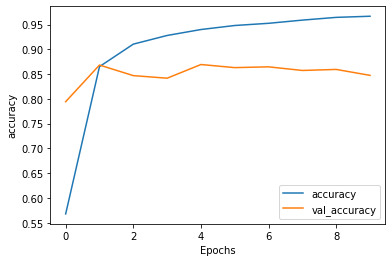

In [37]:
plot_graphs(history, 'accuracy')

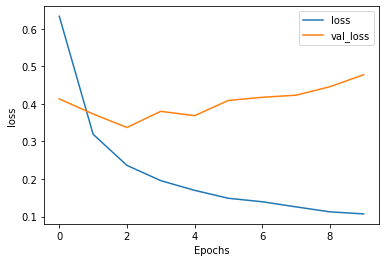

In [38]:
plot_graphs(history, 'loss')

# Stack two or more LSTM layers

* Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

 1. Return either the full sequences of successive outputs for each timestep (a 3D tensor of shape (`batch_size, timesteps, output_features`)).
 2. Return only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features))

In [39]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [40]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [41]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 78s 199ms/step - loss: 0.6634 - accuracy: 0.5420 - val_loss: 0.4894 - val_accuracy: 0.7792
Epoch 2/10
391/391 [==============================] - 77s 196ms/step - loss: 0.3785 - accuracy: 0.8418 - val_loss: 0.3704 - val_accuracy: 0.8307
Epoch 3/10
391/391 [==============================] - 76s 195ms/step - loss: 0.2696 - accuracy: 0.8992 - val_loss: 0.3429 - val_accuracy: 0.8505
Epoch 4/10
391/391 [==============================] - 77s 196ms/step - loss: 0.2215 - accuracy: 0.9215 - val_loss: 0.3520 - val_accuracy: 0.8589
Epoch 5/10
391/391 [==============================] - 76s 196ms/step - loss: 0.1906 - accuracy: 0.9372 - val_loss: 0.3804 - val_accuracy: 0.8552
Epoch 6/10
391/391 [==============================] - 76s 194ms/step - loss: 0.1603 - accuracy: 0.9508 - val_loss: 0.4119 - val_accuracy: 0.8573
Epoch 7/10
391/391 [==============================] - 76s 195ms/step - loss: 0.1447 - accuracy: 0.9574 - val_loss: 0.4597 - val_ac

In [42]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 35s 89ms/step - loss: 0.5258 - accuracy: 0.8476
Test Loss: 0.525766134262085
Test Accuracy: 0.8475599884986877


In [ ]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

In [ ]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

In [ ]:
plot_graphs(history, 'accuracy')


In [ ]:
plot_graphs(history, 'loss')